In [17]:
# autoreload to reload modules when they change
%load_ext autoreload
%autoreload 2

import rollout
from torch import optim
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:

d_model = 256
n_contexts = 2
n_tokens = 12
sequence_length = 8
n_heads = 1
# need to use n_tokens - n_contexts to keep n_tokens at 12
dataset = rollout.dataset.MultiTaskDataset(n_tokens-n_contexts, sequence_length)

In [19]:
n_tokens

12

In [20]:

simpleModel = rollout.models.FlexibleTransformer(d_model, n_tokens, sequence_length, n_heads, n_attn_layers=1)
optimizer = optim.AdamW(simpleModel.parameters(), lr=0.001)
criterion = nn.functional.cross_entropy

simple_train_losses, simple_test_losses = rollout.models.optimize_model(simpleModel, criterion, optimizer, dataset, n_epochs=500, batch_size=1024)

Epoch 0: Train Loss: 2.69146466255188, Test Loss: 2.489514112472534
Epoch 100: Train Loss: 1.5529214143753052, Test Loss: 1.5334750413894653
Epoch 200: Train Loss: 1.4913663864135742, Test Loss: 1.4900932312011719
Epoch 300: Train Loss: 1.4868571758270264, Test Loss: 1.474509596824646
Epoch 400: Train Loss: 1.476057529449463, Test Loss: 1.4711016416549683


In [24]:
d_model = 128
n_heads = 2

complexModel = rollout.models.FlexibleTransformer(d_model, n_tokens, sequence_length, n_heads, n_attn_layers=2)
optimizer = optim.AdamW(complexModel.parameters(), lr=0.001)
criterion = nn.functional.cross_entropy

complex_train_losses, complex_test_losses =  rollout.models.optimize_model(complexModel, criterion, optimizer, dataset, n_epochs=500, batch_size=1024)

Epoch 0: Train Loss: 2.75378155708313, Test Loss: 2.5697526931762695
Epoch 100: Train Loss: 0.4077337086200714, Test Loss: 0.4354933202266693
Epoch 200: Train Loss: 0.0006495249108411372, Test Loss: 0.0003753943892661482
Epoch 300: Train Loss: 7.795691635692492e-05, Test Loss: 7.81680500949733e-05
Epoch 400: Train Loss: 6.486126949312165e-05, Test Loss: 5.966384196653962e-05


In [25]:
num_simple_params = sum(p.numel() for p in simpleModel.parameters() if p.requires_grad)
num_complex_params = sum(p.numel() for p in complexModel.parameters() if p.requires_grad)
print(f"Simple model has {num_simple_params} parameters")
print(f"Complex model has {num_complex_params} parameters")

Simple model has 269324 parameters
Complex model has 135180 parameters


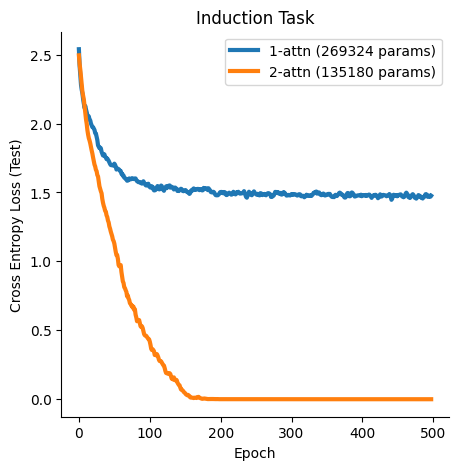

In [26]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(rollout.utils.movmean(np.array(simple_train_losses), 3), label=f"1-attn ({num_simple_params} params)", lw=3)
ax.plot(rollout.utils.movmean(np.array(complex_test_losses), 3), label=f"2-attn ({num_complex_params} params)", lw=3)
ax.set_ylabel("Cross Entropy Loss (Test)")  
ax.legend()
ax.set_title("Induction Task")
ax.set_xlabel("Epoch")
sns.despine()

In [27]:
X, y = dataset.generate_batch(100, type="test")

simple_x, simple_weights = simpleModel.forward_with_weights(X)
complex_x, complex_weights = complexModel.forward_with_weights(X)
y_pred_simple = torch.argmax(simple_x, dim=1)
y_pred_complex = torch.argmax(complex_x, dim=1)

# now print some performance stats
#corrcoef
cc_simple = np.corrcoef(y_pred_simple.detach().numpy(), y)[0, 1]
cc_complex = np.corrcoef(y_pred_complex.detach().numpy(), y)[0, 1]

# calculate percent correct classification
pcc_simple = np.mean(y_pred_simple.detach().numpy() == y.numpy())
pcc_complex = np.mean(y_pred_complex.detach().numpy() == y.numpy())

print(f"Simple Model \tCC: {cc_simple:.2f} \t PCC: {pcc_simple:.2f}")
print(f"Complex Model \tCC: {cc_complex:.2f} \t PCC: {pcc_complex:.2f}")


Simple Model 	CC: 0.10 	 PCC: 0.30
Complex Model 	CC: 1.00 	 PCC: 1.00


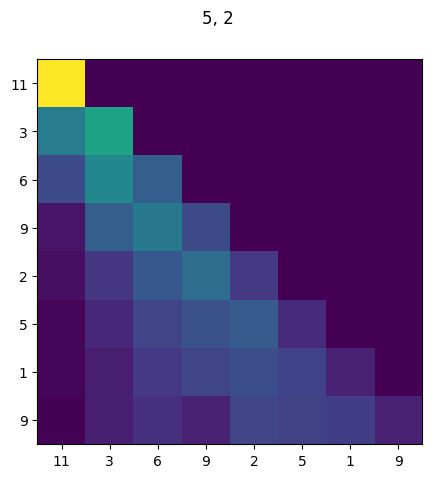

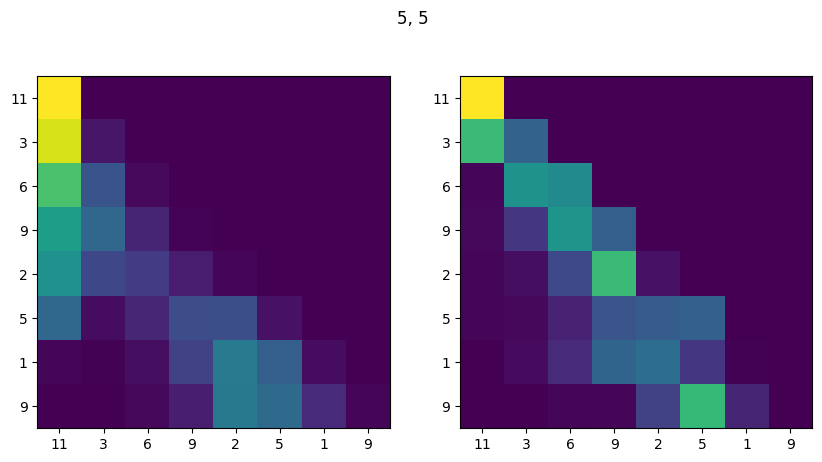

In [33]:
sample = np.random.randint(0, len(y))


fig, ax = plt.subplots(1, len(simple_weights), figsize=(10, 5))
for ix, aw in enumerate(simple_weights):
    plt.imshow(aw[sample])
    plt.xticks(np.arange(sequence_length), labels=X[sample].numpy())
    plt.yticks(np.arange(sequence_length), labels=X[sample].numpy())
fig.suptitle(f"{y[sample]}, {y_pred_simple[sample]}")

fig, ax = plt.subplots(1, len(complex_weights), figsize=(10, 5))
for ix, aw in enumerate(complex_weights):
    ax[ix].imshow(aw[sample])
    ax[ix].set_xticks(np.arange(sequence_length), labels=X[sample].numpy())
    ax[ix].set_yticks(np.arange(sequence_length), labels=X[sample].numpy())

fig.suptitle(f"{y[sample]}, {y_pred_complex[sample]}")
plt.show()